# Set-Up

In [ ]:
!pip3 install datasets
!pip install accelerate -U

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize
import transformers
from transformers import DefaultDataCollator, Trainer, TrainingArguments, EarlyStoppingCallback, ViTImageProcessor, ViTForImageClassification
from datasets import load_dataset, load_metric, DatasetDict
from PIL import Image
import accelerate
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import datasets

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 18.

# Importar datos

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/archive.zip" -d "/kaggle"

Streaming output truncated to the last 5000 lines.
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: /kaggle/Alzhe

# Cargar datos

In [ ]:
checkpoint = 'google/vit-base-patch16-224'

dataset = load_dataset("imagefolder", data_dir="/kaggle/Alzheimer_s Dataset")

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

print(labels)
print(dataset.column_names)

Resolving data files:   0%|          | 0/5121 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1279 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
{'train': ['image', 'label'], 'test': ['image', 'label']}


# Visualizar los datos

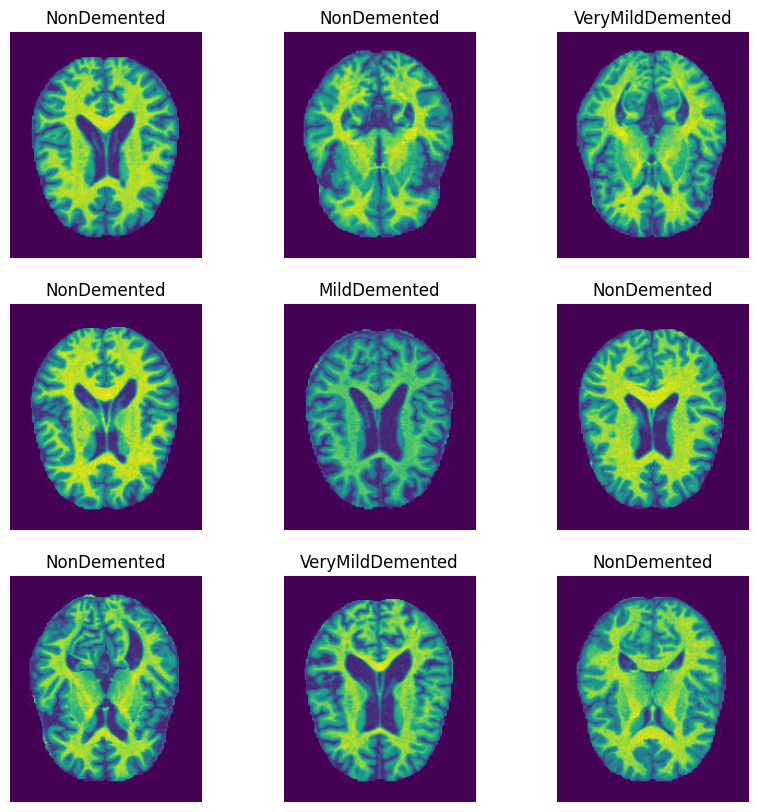

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    index = random.randint(0, len(dataset["train"]) - 1)
    ax = plt.subplot(3, 3, i + 1)
    img = dataset["train"][index]["image"]
    label = id2label[str(dataset["train"][index]["label"])]
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()

# Preprocesamiento de los datos

In [ ]:
image_processor = ViTImageProcessor.from_pretrained(checkpoint)

def process_example(example):
    inputs = image_processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

def transform(example_batch):
    images = [img.convert("RGB") if img.mode != "RGB" else img for img in example_batch['image']]
    inputs = image_processor(images, return_tensors='pt')
    inputs['labels'] = example_batch['label']

    return inputs

proc_dataset = dataset.with_transform(transform)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

print(image_processor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



# Data augmentation

In [20]:
augmentation_transforms = Compose([
    Resize(size=(image_processor.size['height'], image_processor.size['width'])),
    RandomRotation(degrees=45),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ToTensor()
])

normal_transforms = Compose([
    Resize(size=(image_processor.size['height'], image_processor.size['width'])),
    ToTensor()
])

def transform(example_batch, is_aug=True):
    if is_aug:
        images = [augmentation_transforms(img.convert("RGB")) for img in example_batch['image']]
    else:
        images = [normal_transforms(img.convert("RGB")) for img in example_batch['image']]

    inputs = {
        'pixel_values': torch.stack(images),  # Stack images into a single tensor
        'labels': example_batch['label']  # Labels stay the same
    }
    return inputs

new_transforms = Compose([
    Resize(size=(image_processor.size['height'], image_processor.size['width'])),  # Resize the image to the expected input size
    ToTensor(),
])

def new_transform(example_batch):
    images = [new_transforms(img.convert("RGB")) for img in example_batch['image']]

    inputs = {
        'pixel_values': torch.stack(images),
        'labels': example_batch['label']
    }
    return inputs

normal_train_dataset = dataset.with_transform(lambda batch: transform(batch, is_aug=False))

aug_train_dataset = dataset.with_transform(lambda batch: transform(batch, is_aug=True))

<class 'datasets.arrow_dataset.Dataset'>
10242
{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 'labels': 0}
{'pixel_values': tensor([[[0

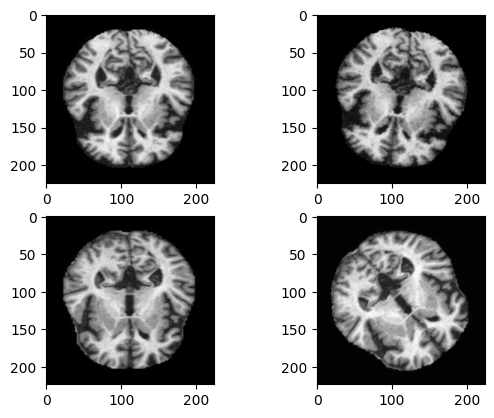

In [21]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(normal_train_dataset['train'][11]['pixel_values'].permute(1, 2, 0))
axarr[0,1].imshow(aug_train_dataset['train'][11]['pixel_values'].permute(1, 2, 0))
axarr[1,0].imshow(normal_train_dataset['train'][21]['pixel_values'].permute(1, 2, 0))
axarr[1,1].imshow(aug_train_dataset['train'][21]['pixel_values'].permute(1, 2, 0))

print(type(dataset['train']))

combined_train_dataset = DatasetDict({"train": datasets.concatenate_datasets([normal_train_dataset["train"], aug_train_dataset["train"]])})
combined_test_dataset = DatasetDict({"test": datasets.concatenate_datasets([normal_train_dataset["test"], aug_train_dataset["test"]])})

combined_dataset = DatasetDict({
    'train': combined_train_dataset['train'],
    'test': combined_test_dataset['test']
})

combined_dataset = combined_dataset.shuffle(seed=42)
new_dataset = combined_dataset.with_transform(lambda batch: new_transform(batch))

# Modelo

In [30]:
model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.05)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=1,
    eval_strategy="epoch",
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_strategy="epoch"
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-5,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.8,
    #amsgrad=True
)

# optimizer = torch.optim.Adagrad(
#     model.parameters(),
#     lr=0.002,
#     lr_decay=0.1,  # Puedes ajustar lr_decay para que el learning rate decrezca a medida que entrenas
#     weight_decay=0.1,  # La regularización L2 ya está aplicada
#     eps=1e-08  # Evita divisiones por cero en actualizaciones
# )

# optimizer = torch.optim.RMSprop(
#     model.parameters(),
#     lr=0.002,
#     alpha=0.99,  # Parámetro para controlar la media móvil de los cuadrados del gradiente
#     eps=1e-08,
#     weight_decay=0.1,
#     momentum=0.1  # Si quieres agregar momentum
# )

from torch.optim.lr_scheduler import ReduceLROnPlateau

#scheduler = transformers.get_polynomial_decay_schedule_with_warmup(optimizer, num_warmup_steps=training_args.warmup_steps, num_training_steps=training_args.num_train_epochs)
#scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=training_args.warmup_steps, num_training_steps=training_args.num_train_epochs
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.01,
    min_lr=1e-8
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()

trainer.evaluate(eval_dataset=new_dataset["test"])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.067600,1.453356,0.681001,0.592471,0.681001,0.666186
2,0.041400,1.591686,0.717748,0.805568,0.717748,0.716602
3,0.130700,1.479535,0.723221,0.565536,0.723221,0.705970
4,0.002200,1.463512,0.750586,0.787000,0.750586,0.741782
5,0.000100,1.827160,0.730258,0.756611,0.730258,0.709276
6,0.000100,1.774111,0.738858,0.753344,0.738858,0.725275


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.4533555507659912,
 'eval_accuracy': 0.6810007818608288,
 'eval_precision': 0.5924710599191629,
 'eval_recall': 0.6810007818608288,
 'eval_f1': 0.666185973173823,
 'eval_runtime': 15.9022,
 'eval_samples_per_second': 160.858,
 'eval_steps_per_second': 10.062,
 'epoch': 6.0}

# Búsqueda hiperparámetros

In [ ]:
!pip install optuna
import optuna

def model_init():
    return ViTForImageClassification.from_pretrained(checkpoint)

def hyperparameter_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 10, 15),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.1, 0.3),
        "weight_decay": trial.suggest_float("weight_decay", 0.1, 0.5),
        "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "cosine_with_restarts"])
        }

training_args = TrainingArguments(
    output_dir="./results",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    metric_for_best_model="eval_loss",
    load_best_model_at_end=True
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    tokenizer=image_processor,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset["test"],
    compute_metrics=compute_metrics
)

best_run = trainer.hyperparameter_search(
    direction="minimize",
    hp_space=hyperparameter_space,
    n_trials=10,
    backend="optuna"
)